In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

path = os.path.join("X-IIoTID dataset.csv")  
try:
    df = pd.read_csv(path, low_memory=False)
    print(f"✅ Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas.")
except FileNotFoundError:
    print("❌ Error: No se encontró el archivo.")

✅ Datos cargados: 820834 filas, 68 columnas.


In [2]:
random_state = 42

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820834 entries, 0 to 820833
Data columns (total 68 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Date                         820503 non-null  object
 1   Timestamp                    820537 non-null  object
 2   Scr_IP                       820834 non-null  object
 3   Scr_port                     820834 non-null  object
 4   Des_IP                       820834 non-null  object
 5   Des_port                     820834 non-null  object
 6   Protocol                     820834 non-null  object
 7   Service                      820834 non-null  object
 8   Duration                     820834 non-null  object
 9   Scr_bytes                    820834 non-null  object
 10  Des_bytes                    820834 non-null  object
 11  Conn_state                   820834 non-null  int64 
 12  missed_bytes                 820834 non-null  object
 13  is_syn_only   

In [4]:
from sklearn.model_selection import train_test_split

"""Divide los datos en entrenamiento, validación y prueba."""
X = df.drop(columns=['class1', 'class2', 'class3'])
y_class3 = df['class3'].map({'Normal': 0, 'Attack': 1})
y_class2 = df['class2']
y_class1 = df['class1']

X_train, X_temp, y_train_class3, y_temp_class3, y_train_class2, y_temp_class2, y_train_class1, y_temp_class1 = train_test_split(
    X, y_class3, y_class2, y_class1, test_size=0.3, random_state=random_state, stratify=y_class3, shuffle=True
)

X_val, X_test, y_val_class3, y_test_class3, y_val_class2, y_test_class2, y_val_class1, y_test_class1 = train_test_split(
    X_temp, y_temp_class3, y_temp_class2, y_temp_class1, test_size=0.5, random_state=random_state, stratify=y_temp_class3, shuffle=True
)

# Resetear índices para evitar desalineaciones
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)  # Opcional

y_train_class3 = y_train_class3.reset_index(drop=True)
y_val_class3 = y_val_class3.reset_index(drop=True)
y_test_class3 = y_test_class3.reset_index(drop=True)  # Opcional

y_train_class2 = y_train_class2.reset_index(drop=True)
y_val_class2 = y_val_class2.reset_index(drop=True)
y_test_class2 = y_test_class2.reset_index(drop=True)  # Opcional

y_train_class1 = y_train_class1.reset_index(drop=True)
y_val_class1 = y_val_class1.reset_index(drop=True)
y_test_class1 = y_test_class1.reset_index(drop=True)  # Opcional

In [5]:
import pandas as pd
def fix_dtype(df, umbral_numerico=0.7):
    object_cols = df.select_dtypes(include=['object']).columns
    int_cols = df.select_dtypes(include=['int64']).columns
    bool_cols = df.select_dtypes(include=['bool']).columns

    # Convertir booleanos a float
    df[bool_cols] = df[bool_cols].astype(float)

    for col in object_cols:
        valores_unicos = df[col].dropna().unique()

        if {"true", "false"} <= set(valores_unicos):  # Verifica si ambos existen
            df[col] = df[col].map({'true': 1, 'false': 0}).astype(float)
        else:
            converted = pd.to_numeric(df[col], errors='coerce')
            if converted.notna().mean() > umbral_numerico:
                df[col] = converted.astype(float)

    for col in int_cols:
        df[col] = df[col].astype(float)

    return df

def delete_ip_port(df):
    """Elimina las columnas 'ip' y 'port'."""
    lista = ['Scr_IP', 'Scr_port', 'Des_IP', 'Des_port', 'Scr_bytes', 'Des_bytes', 'Scr_pkts', 
                            'Des_pkts', 'Scr_ip_bytes', 'Des_ip_bytes', 'Scr_packts_ratio', 'Des_pkts_ratio',
                            'Scr_bytes_ratio', 'Des_bytes_ratio']

    return df.drop(columns=lista)

In [6]:
import numpy as np
# Reemplazos comunes de valores
common_replacements = {
    '-': np.nan,
    '?': np.nan,
    'nan': np.nan,
}

def replace_common_values(df):
    """Reemplaza valores comunes como '-', '?' y 'nan' por NaN."""
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].replace(common_replacements)
    return df

def fix_mayus(df):
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].str.lower()
    return df


In [7]:
from sklearn.impute import KNNImputer, SimpleImputer

# Definir los imputadores
imputers = {
    'categorical': {
        'most_frequent': SimpleImputer(strategy='most_frequent'),
        'knn': KNNImputer(n_neighbors=5),
        'constant': SimpleImputer(strategy='constant', fill_value='missing')
    },
    'numeric': {
        'mean': SimpleImputer(strategy='mean'),
        'median': SimpleImputer(strategy='median')
    }
}

from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import RobustScaler

# Definir escaladores
scalers = {
    "robust": RobustScaler(),
    "standard": StandardScaler()
}

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Definir codificadores
encoders = {
    "one_hot": OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
    "ordinal": OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
}

In [8]:
imputador_cat= imputers['categorical']['most_frequent']
imputador_num = imputers['numeric']['mean']
normalizacion = scalers['robust']
decodificador = encoders['one_hot']

In [9]:
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier


def matriz_correlacion(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    correlation_matrix = df[numeric_cols].corr()
    return correlation_matrix

def correlacion_pares(df, umbral):
    df = matriz_correlacion(df)
    # Toma solo la parte superior de la matriz para evitar duplicados
    upper_tri = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))

    # Identifica pares altamente correlacionados
    correlated_pairs = []
    for col in upper_tri.columns:
        for row in upper_tri.index:
            if upper_tri.loc[row, col] > umbral:
                correlated_pairs.append((row, col))

    # Selecciona las columnas a eliminar (de cada par, se elimina la que aparece como columna)
    alta_corr_pares = [col for col in upper_tri.columns if any(upper_tri[col] > umbral)]
    
    return alta_corr_pares

def correlacion_respecto_objetivo(df, target, umbral):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    # Calculamos la correlación con la variable objetivo
    target_correlation = df[numeric_cols].corrwith(target).abs().sort_values(ascending=True)

    # Nos quedamos solo con las características que tengan correlación >= 0.1
    baja_corr_respecto_obj = target_correlation[target_correlation < umbral].index.tolist()

    return baja_corr_respecto_obj

def seleccionar_variables_pca(X_train, X_val, n_components, num_top_features):
    """
    Aplica PCA para seleccionar las características más influyentes, pero mantiene los datos originales.
    
    Parámetros:
        - X_train: DataFrame de entrenamiento
        - X_val: DataFrame de validación
        - n_components: float/int, cantidad de componentes principales o porcentaje de varianza a retener
        - num_top_features: int, número de características más influyentes a seleccionar

    Retorna:
        - X_train_filtrado: DataFrame de entrenamiento con las características seleccionadas
        - X_val_filtrado: DataFrame de validación con las características seleccionadas
    """

    # Si usas el sample, cambialo en las lineas necesarias
    # X_train_sample = X_train.sample(n=300000, random_state=42) # Seleccionar una muestra de 300,000 instancias como en el articulo
    
    # Aplicar PCA (sin guardar la transformación)
    pca = PCA(n_components=n_components, random_state=42)
    pca.fit(X_train)  # Solo ajustamos el modelo, no transformamos los datos

    # Obtener nombres originales de las variables
    original_feature_names = np.array(X_train.columns)

    # Contador de importancia de características en PCA
    feature_counter = Counter()
    
    for comp in pca.components_:
        top_indices = np.argsort(np.abs(comp))[-num_top_features:]  # Índices de las más importantes
        top_features = original_feature_names[top_indices]  # Obtener nombres
        feature_counter.update(top_features)  # Contar ocurrencias

    # Seleccionar las variables más influyentes ordenadas por frecuencia de aparición
    variables_pca = [feature for feature, _ in feature_counter.most_common()]

    # Filtrar las variables seleccionadas en los conjuntos de datos
    X_train_filtrado = X_train[variables_pca]
    X_val_filtrado = X_val[variables_pca]
    
    return X_train_filtrado, X_val_filtrado

def seleccionar_variables_rfe(X_train, X_val, y_train, num_features):
    # Modelo base para RFE
    modelo_rf = DecisionTreeClassifier(random_state=42)

    # Aplicar RFE para seleccionar las 20 mejores características
    rfe = RFE(estimator=modelo_rf, n_features_to_select=num_features, step=3)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_val_rfe = rfe.transform(X_val)

    # Ver qué variables fueron seleccionadas
    selected_features = X_train.columns[rfe.support_]
    
    X_train_filtrado = X_train[selected_features]
    X_val_filtrado = X_val[selected_features]
    
    return X_train_filtrado, X_val_filtrado


def seleccionar_variables_randomForest(X_train, X_val, y_train, sample_weight_train, num_features):
    # Entrenar el modelo RandomForest con los pesos
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train, sample_weight=sample_weight_train)

    # Obtener importancia de características
    feature_importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    caracteristicas_imp_rf = feature_importances.head(num_features) 
    caracteristicas_imp_rf = caracteristicas_imp_rf.Feature.to_list()
    # print(caracteristicas_imp_rf)

    X_train_processed = X_train[caracteristicas_imp_rf]
    X_val_processed = X_val[caracteristicas_imp_rf]
    
    X_train_processed.shape
        
    return X_train_processed, X_val_processed


def proyectar_tsne(X_train, X_val, n_components, perplexity, max_iter, sample_size, random_state):
    """
    Aplica T-SNE para proyectar los datos a un espacio de menor dimensión.
    
    Parámetros:
        - X_train: DataFrame de entrenamiento
        - X_val: DataFrame de validación
        - n_components: int, número de dimensiones del embedding
        - perplexity: float, parámetro de T-SNE
        - n_iter: int, número de iteraciones
        - sample_size: int, cantidad de instancias a muestrear para T-SNE
        - random_state: int, semilla para reproducibilidad

    Retorna:
        - X_train_tsne: DataFrame de entrenamiento con la proyección T-SNE
        - X_val_tsne: DataFrame de validación con la proyección T-SNE
    """
    # Concatenar datos y muestrear si es necesario
    X_all = pd.concat([X_train, X_val])
    if X_all.shape[0] > sample_size:
        X_all_sample = X_all.sample(n=sample_size, random_state=random_state)
    else:
        X_all_sample = X_all.copy()

    # Aplicar T-SNE
    tsne = TSNE(n_components=n_components, perplexity=perplexity, max_iter=max_iter, random_state=random_state)
    X_all_tsne = tsne.fit_transform(X_all_sample)
    df_tsne = pd.DataFrame(X_all_tsne, index=X_all_sample.index, columns=[f'tsne_{i+1}' for i in range(n_components)])
    
    # Separar proyección en conjuntos de entrenamiento y validación
    X_train_tsne = df_tsne.loc[df_tsne.index.intersection(X_train.index)]
    X_val_tsne = df_tsne.loc[df_tsne.index.intersection(X_val.index)]
    
    
    return X_train_tsne, X_val_tsne

In [10]:
def calculo_varianza(df):
    """Calcula las varianzas de las columnas de un DataFrame y devuelve las que tienen varianza igual a cero."""
    varianzas = df.var()

    # Identificar columnas con varianza igual a cero
    variables_con_varianza_cero = [col for col, varianza in varianzas.items() if varianza == 0]
    
    return variables_con_varianza_cero

In [11]:
def outliers(df):
    df_numeric = df.select_dtypes(include=['float', 'int'])  # Seleccionar solo columnas numéricas

    Q1 = df_numeric.quantile(0.25)
    Q3 = df_numeric.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Crear una máscara para eliminar filas con al menos un outlier
    mask = ~((df_numeric < lower_bound) | (df_numeric > upper_bound)).any(axis=1)

    df_clean = df[mask]  # Conservar solo filas sin outliers

    print(f"Outliers eliminados con IQR: {len(df) - len(df_clean)}")

    return df_clean  # Retorna el DataFrame sin outliers

In [12]:
X_train = replace_common_values(X_train)
X_train = fix_mayus(X_train)
X_train = fix_dtype(X_train)
X_train = delete_ip_port(X_train)
# X_train = outliers(X_train)  


y_train_class3 = y_train_class3.loc[X_train.index]
y_train_class2 = y_train_class2.loc[X_train.index]
y_train_class1 = y_train_class1.loc[X_train.index]

X_val = replace_common_values(X_val)
X_val = fix_mayus(X_val)
X_val = fix_dtype(X_val)
X_val = delete_ip_port(X_val)
# X_val = outliers(X_val)

y_val_class3 = y_val_class3.loc[X_val.index]
y_val_class2 = y_val_class2.loc[X_val.index]
y_val_class1 = y_val_class1.loc[X_val.index]

In [13]:
X_train['Instancia_completa'] = X_train.notnull().all(axis=1).astype(int)
X_val['Instancia_completa'] = X_val.notnull().all(axis=1).astype(int)

completas = X_train['Instancia_completa'].sum()
incompletas = len(X_train) - completas
print(f"✅ Instancias completas: {completas}, incompletas: {incompletas}")
sample_weight_train = X_train['Instancia_completa'].replace({1: 3, 0: 1})

columnas_no_comprobar = [col for col in X_train.columns if col not in ['Timestamp', 'Date', 'Instancia_completa'] and X_train[col].dtypes != 'object']
variables_con_varianza_cero = calculo_varianza(X_train[columnas_no_comprobar])
X_train = X_train.drop(columns=variables_con_varianza_cero)
X_val = X_val.drop(columns=variables_con_varianza_cero)
    
X_train = X_train.drop(columns=['Timestamp', 'Date', 'Instancia_completa'], errors='ignore')
X_val = X_val.drop(columns=['Timestamp', 'Date', 'Instancia_completa'], errors='ignore')

alta_corr_pares = correlacion_pares(X_train, 0.97)
X_train = X_train.drop(columns=alta_corr_pares)
X_val = X_val.drop(columns=alta_corr_pares)

baja_corr_respecto_obj = correlacion_respecto_objetivo(X_train, y_train_class3, 0.025)
X_train = X_train.drop(columns=baja_corr_respecto_obj)
X_val = X_val.drop(columns=baja_corr_respecto_obj)

caracteritisticas_seleccionadas = X_train.columns.tolist()

X_train['Protocol'] = X_train['Protocol'].fillna("missing")
X_val['Protocol'] = X_val['Protocol'].fillna("missing")

✅ Instancias completas: 416933, incompletas: 157650


In [14]:
 # Identificar columnas categóricas, numéricas y booleanas
categorical_cols = X_train.select_dtypes(include=['object']).columns
boolean_cols = X_train.select_dtypes(include=['bool']).columns
if boolean_cols.any():  # Si hay columnas booleanas
    X_train[boolean_cols] = X_train[boolean_cols].astype(float)  # TAL VEZ INNCESESARIO
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

##############################################################################
    
X_train[categorical_cols] = imputador_cat.fit_transform(X_train[categorical_cols])
X_val[categorical_cols] = imputador_cat.transform(X_val[categorical_cols])

X_train[numerical_cols] = imputador_num.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = imputador_num.transform(X_val[numerical_cols])

##############################################################################

X_train_scaled = normalizacion.fit_transform(X_train[numerical_cols])
X_val_scaled = normalizacion.transform(X_val[numerical_cols])

# Convertir las matrices escaladas a DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=[f"{col}_scaled" for col in numerical_cols], index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=[f"{col}_scaled" for col in numerical_cols], index=X_val.index)

##############################################################################

X_train_encoded = decodificador.fit_transform(X_train[categorical_cols])
X_val_encoded = decodificador.transform(X_val[categorical_cols])

# Obtener los nombres de las nuevas columnas codificadas
encoded_cols = decodificador.get_feature_names_out(categorical_cols)

# Convertir las matrices codificadas a DataFrames
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=X_train.index)
X_val_encoded_df = pd.DataFrame(X_val_encoded, columns=encoded_cols, index=X_val.index)

##############################################################################

# Combinar con las características categóricas codificadas
X_train_processed = pd.concat([X_train_scaled_df, X_train_encoded_df], axis=1)
X_val_processed = pd.concat([X_val_scaled_df, X_val_encoded_df], axis=1)

# Opcional: Reordenar las columnas si es necesario
X_train = X_train_processed.reindex(sorted(X_train_processed.columns), axis=1)
X_val = X_val_processed.reindex(sorted(X_val_processed.columns), axis=1)

In [15]:
X_train, X_val = seleccionar_variables_pca(X_train_processed, X_val_processed, n_components=0.95, num_top_features=20)
caracteritisticas_procesadas = X_train.columns.tolist()

In [16]:
X_train.shape

(574583, 34)

In [16]:
from sklearn.utils import resample

X_sample, y_sample_class3, y_sample_class2, y_sample_class1  = resample(
    X_train, 
    y_train_class3, y_train_class2, y_train_class1,
    n_samples=100000,
    replace=False,
    random_state=random_state
)

print(X_sample.shape)
print(y_sample_class3.shape, np.unique(y_sample_class3, return_counts=True))
print(y_sample_class2.shape, np.unique(y_sample_class2, return_counts=True))
print(y_sample_class1.shape, np.unique(y_sample_class1, return_counts=True))

(100000, 34)
(100000,) (array([0, 1], dtype=int64), array([51258, 48742], dtype=int64))
(100000,) (array(['C&C', 'Exfiltration', 'Exploitation', 'Lateral _movement',
       'Normal', 'RDOS', 'Reconnaissance', 'Tampering', 'Weaponization',
       'crypto-ransomware'], dtype=object), array([  328,  2700,   139,  3950, 51258, 17173, 15661,   599,  8135,
          57], dtype=int64))
(100000,) (array(['BruteForce', 'C&C', 'Dictionary', 'Discovering_resources',
       'Exfiltration', 'Fake_notification', 'False_data_injection',
       'Generic_scanning', 'MQTT_cloud_broker_subscription', 'MitM',
       'Modbus_register_reading', 'Normal', 'RDOS', 'Reverse_shell',
       'Scanning_vulnerability', 'TCP Relay', 'crypto-ransomware',
       'fuzzing', 'insider_malcious'], dtype=object), array([ 5692,   328,   342,  2806,  2700,     3,   596,  6259,  2919,
           9,   757, 51258, 17173,   130,  6453,   274,    57,   143,
        2101], dtype=int64))


In [ ]:
from sklearn.manifold import TSNE

# Reducimos a 2D con t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=random_state)
X_tsne = tsne.fit_transform(X_sample)

In [17]:
# np.save('X_tsne.npy', X_tsne)
X_tsne = np.load('X_tsne.npy')

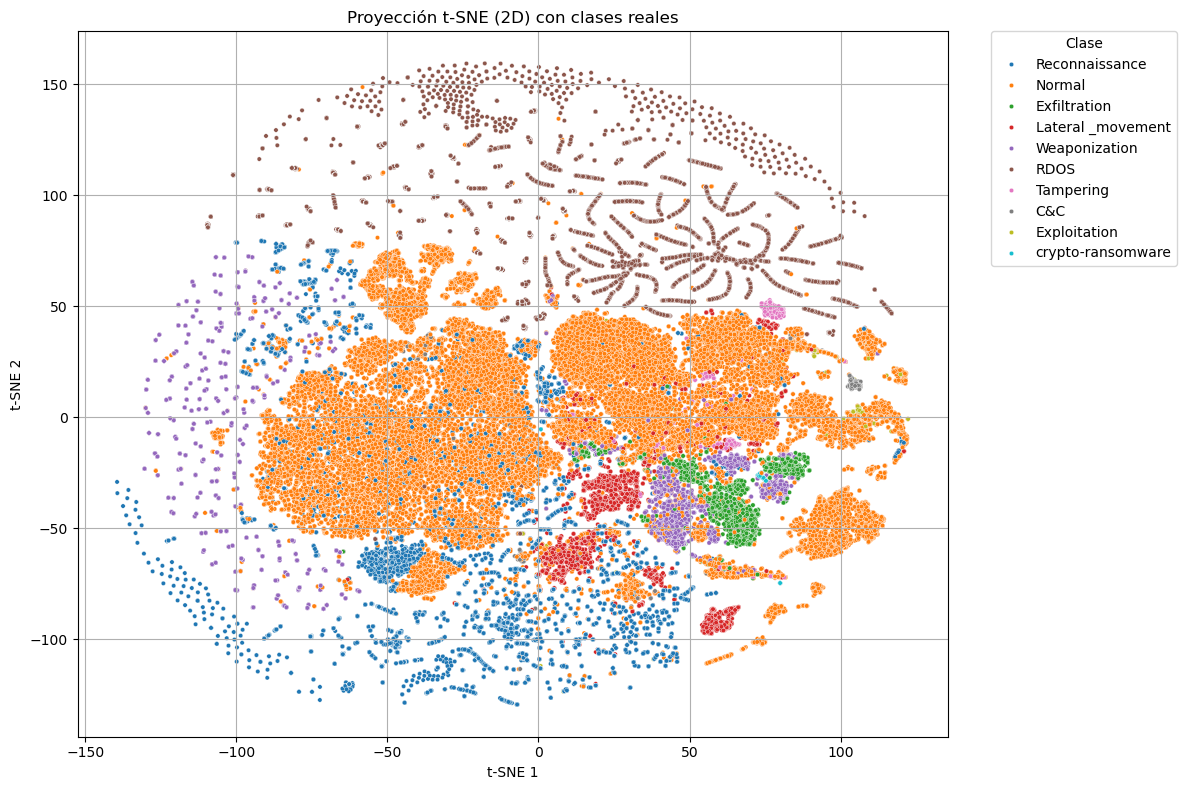

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizamos las clases reales en el espacio t-SNE
plt.figure(figsize=(12, 8))  # Aumentar el tamaño del gráfico

scatter = sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=y_sample_class2,
    palette="tab10",
    s=10,
    legend='full'
)

# Mover la leyenda fuera del gráfico
plt.legend(
    title="Clase",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

plt.title("Proyección t-SNE (2D) con clases reales")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()

In [20]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Establece el valor de k (igual a min_samples)
k = 10

# Calcula las distancias a los k vecinos más cercanos
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_sample)
distances, indices = neighbors_fit.kneighbors(X_sample)

# Tomamos la distancia al k-ésimo vecino (columna -1)
k_distances = np.sort(distances[:, k-1])

Valor óptimo de eps sugerido: 57.773


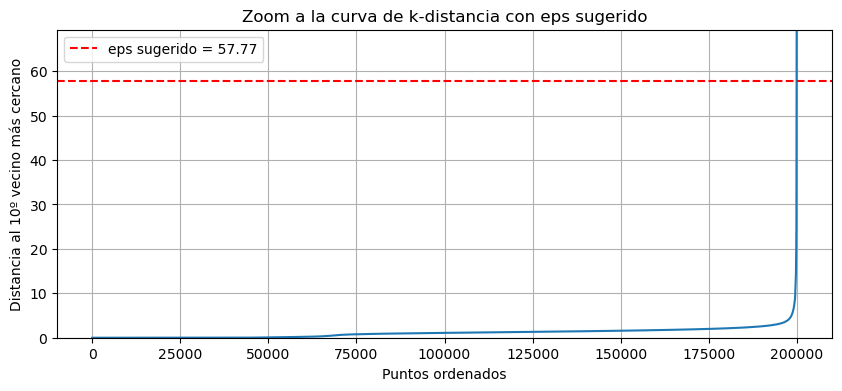

In [23]:
import numpy as np
from kneed import KneeLocator 

def encontrar_eps_optimo(distancias_ordenadas, curva='convex', direccion='increasing'):
    """
    Usa KneeLocator para encontrar el codo en el gráfico de k-distancia.
    
    Parámetros:
        distancias_ordenadas (np.array): Distancias ordenadas al k-ésimo vecino.
        curva (str): 'convex' o 'concave', según la forma de la curva.
        direccion (str): 'increasing' o 'decreasing', según el sentido de la curva.
    
    Retorna:
        eps óptimo (float)
    """
    kneedle = KneeLocator(
        x=range(len(distancias_ordenadas)),
        y=distancias_ordenadas,
        curve=curva,
        direction=direccion
    )
    return kneedle.knee_y  # o kneedle.knee si prefieres el índice

# Uso:
eps_optimo = encontrar_eps_optimo(k_distances)
print(f"Valor óptimo de eps sugerido: {eps_optimo:.3f}")


# Ajustar dinámicamente el límite del eje Y (por ejemplo, 20% por encima del valor óptimo)
margen = eps_optimo * 0.2
y_max = eps_optimo + margen

# Graficar con escala automática
plt.figure(figsize=(10, 4))
plt.plot(k_distances)
plt.axhline(eps_optimo, color='r', linestyle='--', label=f"eps sugerido = {eps_optimo:.2f}")
plt.ylim(0, y_max)
plt.legend()
plt.xlabel("Puntos ordenados")
plt.ylabel("Distancia al 10º vecino más cercano")
plt.title("Zoom a la curva de k-distancia con eps sugerido")
plt.grid(True)
plt.show()

In [ ]:
# import numpy as np
# from sklearn.cluster import DBSCAN
# import gc

# eps_values = np.round(np.linspace(eps_optimo - 2, eps_optimo + 2, num=9), 3)
# eps_values = [eps for eps in eps_values if eps > 0]
# print(eps_values)

# for eps in eps_values:
#     db = DBSCAN(eps=eps, min_samples=10, n_jobs=-1)
#     db.fit(X_sample)
#     labels = db.labels_
#     n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
#     n_noise = list(labels).count(-1)
#     print(f"eps={eps:.1f} → clusters: {n_clusters}, ruido: {n_noise}")
#     del db, labels  # Limpia objetos grandes
#     gc.collect()


[11.995, 12.495, 12.995, 13.495, 13.995, 14.495, 14.995, 15.495, 15.995]


In [ ]:
# import joblib

# # Cargar el modelo desde el archivo
# db = joblib.load('dbscan_model.pkl')

c:\Users\rafae\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DBSCAN from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
from sklearn.cluster import DBSCAN

eps = 10
db = DBSCAN(eps=eps, min_samples=950)

joblib.dump(db, 'dbscan_model.pkl')

eps=10.000 → clusters: 10, ruido: 42036


C:\Users\rafae\AppData\Local\Temp\ipykernel_376\3175643890.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_dbscan = plt.cm.get_cmap('tab10', n_labels)


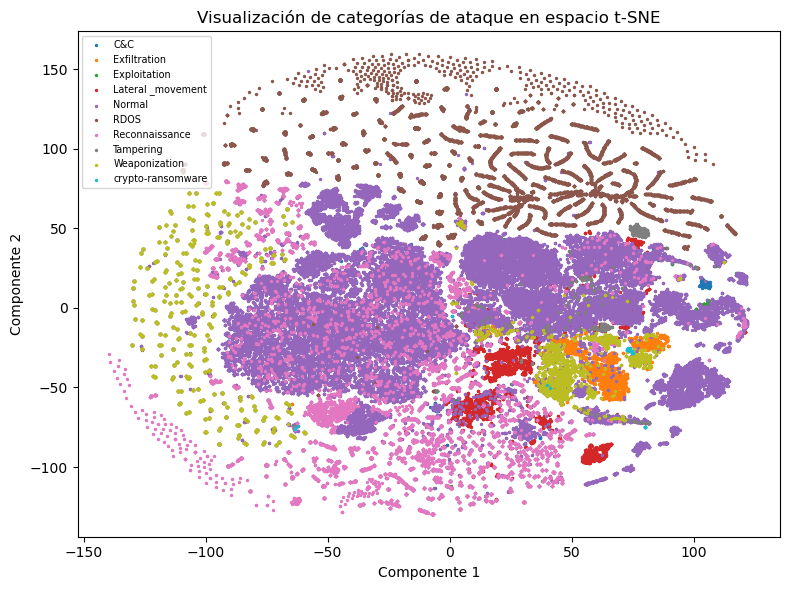

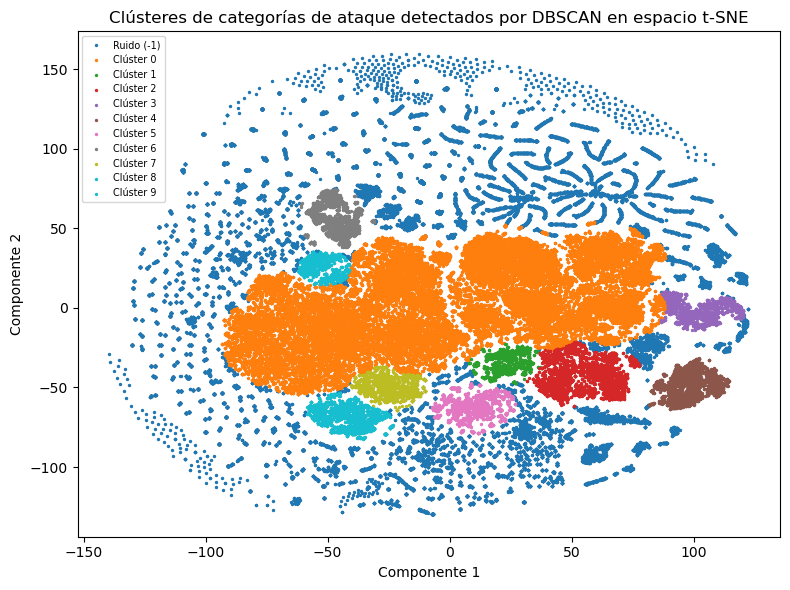

eps=10.000 → clusters: 10, ruido: 42036


C:\Users\rafae\AppData\Local\Temp\ipykernel_376\3175643890.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_dbscan = plt.cm.get_cmap('tab10', n_labels)


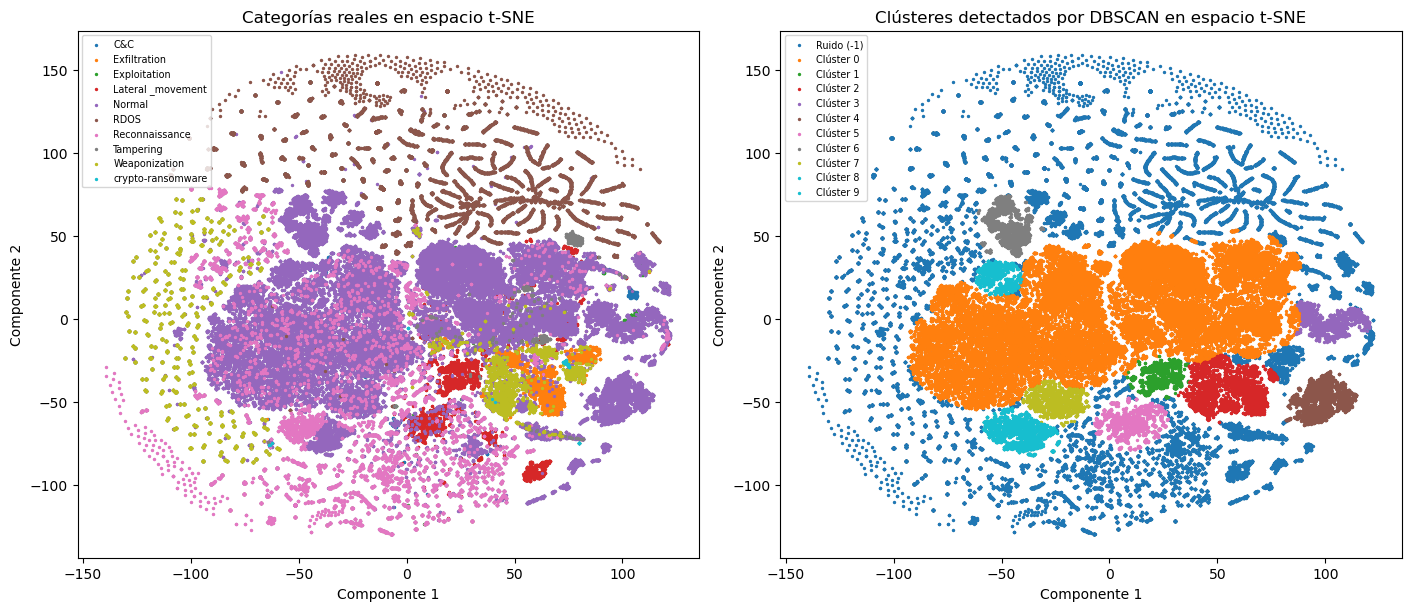

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred = db.fit_predict(X_tsne)
labels = db.labels_

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print(f"eps={eps:.3f} → clusters: {n_clusters}, ruido: {n_noise}")

# Asegurar array
y_pred = np.array(y_pred)

# Colores para DBSCAN
unique_labels = np.unique(y_pred)
n_labels = len(unique_labels)
cmap_dbscan = plt.cm.get_cmap('tab10', n_labels)
label_to_color = {label: cmap_dbscan(i) for i, label in enumerate(unique_labels)}
colors_dbscan = np.array([label_to_color[label] for label in y_pred])

# Colores para clases reales
unique_classes = np.unique(y_sample_class2)
palette_real = sns.color_palette("tab10", len(unique_classes))
class_to_color = {cls: palette_real[i] for i, cls in enumerate(unique_classes)}
colors_real = np.array([class_to_color[cls] for cls in y_sample_class2])

# --- Figura 1: Clases reales ---
plt.figure(figsize=(8, 6))
plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    color='lightgrey', s=2, alpha=0.6, label='_nolegend_'
)
for cls in unique_classes:
    idx = y_sample_class2 == cls
    plt.scatter(
        X_tsne[idx, 0], X_tsne[idx, 1],
        color=class_to_color[cls], s=2, label=f"{cls}"
    )
plt.title("Visualización de categorías de ataque en espacio t-SNE")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(False)
plt.legend(loc='best', fontsize='x-small')
plt.tight_layout()
plt.savefig("clases_reales_tsne.png")  # Guardar como PDF
plt.show()

# --- Figura 2: DBSCAN ---
plt.figure(figsize=(8, 6))
plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    color='lightgrey', s=2, alpha=0.6, label='_nolegend_'
)
for label in unique_labels:
    idx = y_pred == label
    label_name = "Ruido (-1)" if label == -1 else f"Clúster {label}"
    plt.scatter(
        X_tsne[idx, 0], X_tsne[idx, 1],
        color=label_to_color[label], s=2, label=label_name
    )
plt.title("Clústeres de categorías de ataque detectados por DBSCAN en espacio t-SNE")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(False)
plt.legend(loc='best', fontsize='x-small')
plt.tight_layout()
plt.savefig("dbscan_clusters_tsne.png")  # Guardar como PDF
plt.show()














from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- DBSCAN clustering ---
eps = 10
db = DBSCAN(eps=eps, min_samples=950)
y_pred = db.fit_predict(X_tsne)
labels = db.labels_

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print(f"eps={eps:.3f} → clusters: {n_clusters}, ruido: {n_noise}")

# Asegurar array
y_pred = np.array(y_pred)

# --- Colores para DBSCAN ---
unique_labels = np.unique(y_pred)
n_labels = len(unique_labels)
cmap_dbscan = plt.cm.get_cmap('tab10', n_labels)
label_to_color = {label: cmap_dbscan(i) for i, label in enumerate(unique_labels)}
colors_dbscan = np.array([label_to_color[label] for label in y_pred])

# --- Colores para clases reales ---
unique_classes = np.unique(y_sample_class2)
palette_real = sns.color_palette("tab10", len(unique_classes))
class_to_color = {cls: palette_real[i] for i, cls in enumerate(unique_classes)}
colors_real = np.array([class_to_color[cls] for cls in y_sample_class2])

# --- Figura combinada ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

# Subfigura 1: Clases reales
axes[0].scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    color='lightgrey', s=2, alpha=0.6, label='_nolegend_'
)
for cls in unique_classes:
    idx = y_sample_class2 == cls
    axes[0].scatter(
        X_tsne[idx, 0], X_tsne[idx, 1],
        color=class_to_color[cls], s=2, label=str(cls)
    )
axes[0].set_title("Categorías reales en espacio t-SNE")
axes[0].set_xlabel("Componente 1")
axes[0].set_ylabel("Componente 2")
axes[0].legend(fontsize='x-small', loc='best')

# Subfigura 2: DBSCAN
axes[1].scatter(
    X_tsne[:, 0], X_tsne[:, 1],
    color='lightgrey', s=2, alpha=0.6, label='_nolegend_'
)
for label in unique_labels:
    idx = y_pred == label
    label_name = "Ruido (-1)" if label == -1 else f"Clúster {label}"
    axes[1].scatter(
        X_tsne[idx, 0], X_tsne[idx, 1],
        color=label_to_color[label], s=2, label=label_name
    )
axes[1].set_title("Clústeres detectados por DBSCAN en espacio t-SNE")
axes[1].set_xlabel("Componente 1")
axes[1].set_ylabel("Componente 2")
axes[1].legend(fontsize='x-small', loc='best')

# Guardar figura combinada
plt.savefig("comparacion_tsne_dbscan.png", dpi=300)
plt.show()


In [148]:
import pandas as pd
import numpy as np

# Convertir a arrays por si acaso
y_pred = np.array(y_pred)
y_true = np.array(y_sample_class2)

# Crear DataFrame conjunto
df = pd.DataFrame({
    'cluster': y_pred,
    'real': y_true
})

# Agrupar por cluster y clase real
tabla = df.groupby(['cluster', 'real']).size().unstack(fill_value=0)

# Calcular porcentaje por cluster
tabla_pct = tabla.div(tabla.sum(axis=1), axis=0)

# Mostrar distribución absoluta
print("📊 Distribución real de clases por clúster (conteo):")
print(tabla)

# Mostrar proporción por clúster
print("\n📈 Porcentaje de clases reales por clúster:")
print(tabla_pct)

# Interpretación 1: basado en % de clase 'Normal'
print("\n🧠 Interpretación basada en proporción de clase 'Normal':")
for cluster in tabla_pct.index:
    pct_normal = tabla_pct.loc[cluster].get("Normal", 0)
    tipo = "Anomalía (ataque)" if pct_normal < 0.5 else "Normal"
    print(f"Clúster {cluster}: {pct_normal:.2%} Normal → {tipo}")

# Interpretación 2: basado en clase mayoritaria == 1
print("\n🔍 Interpretación basada en clase mayoritaria igual a '1' (ataque):")
for cluster in tabla_pct.index:
    mayoritaria = tabla_pct.columns[tabla_pct.loc[cluster].argmax()]
    tipo = "Anomalía (ataque)" if mayoritaria == 1 else "Normal"
    print(f"Clúster {cluster}: clase mayoritaria '{mayoritaria}' → {tipo}")


# Crear DataFrame solo con y_pred
df_ypred = pd.DataFrame({'cluster_predicho': y_pred})

# Guardar como CSV en el directorio actual
df_ypred.to_csv("y_pred_dbscan.csv", index=False)

print("✅ Archivo 'y_pred_dbscan.csv' guardado en el directorio actual.")


📊 Distribución real de clases por clúster (conteo):
real     C&C  Exfiltration  Exploitation  Lateral _movement  Normal   RDOS  \
cluster                                                                      
-1       222           585            58                927    6182  16742   
 0        52           373            17                637   34273    430   
 1         0             0             0               1307      26      0   
 2         0          1742             0                  1     526      0   
 3         0             0            60                  0    1817      0   
 4         0             0             1                  0    2539      0   
 5        44             0             3               1078     182      0   
 6         0             0             0                  0    2146      0   
 7         6             0             0                  0    1511      1   
 8         0             0             0                  0    1018      0   
 9         4

In [149]:
# Mapear clústeres a 0=Normal, 1=Ataque según la regla < 50% Normal
clusters_anomalos = tabla_pct.index[tabla_pct["Normal"] < 0.5].tolist()

# Nueva y_pred binaria: 1 si el clúster es considerado ataque
y_pred_bin = np.array([1 if c in clusters_anomalos else 0 for c in y_pred])

In [150]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Matriz de confusión
print("Matriz de confusión:")
print(confusion_matrix(y_sample_class3, y_pred_bin))

# Accuracy general
accuracy = accuracy_score(y_sample_class3, y_pred_bin)
precision = precision_score(y_sample_class3, y_pred_bin, average='binary')
recall = recall_score(y_sample_class3, y_pred_bin, average='binary')
f1 = f1_score(y_sample_class3, y_pred_bin, average='binary')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

# También puedes mostrar todo junto:
print("\nReporte completo:")
print(classification_report(y_sample_class3, y_pred_bin, target_names=["Normal", "Ataque"]))


Matriz de confusión:
[[43324  7934]
 [ 5171 43571]]

Accuracy: 0.8690
Precision: 0.8460
Recall:    0.8939
F1-score:  0.8693

Reporte completo:
              precision    recall  f1-score   support

      Normal       0.89      0.85      0.87     51258
      Ataque       0.85      0.89      0.87     48742

    accuracy                           0.87    100000
   macro avg       0.87      0.87      0.87    100000
weighted avg       0.87      0.87      0.87    100000

